In [5]:
#import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import skimage
#from tensorflow import keras
from skimage import transform
from skimage import data
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.filters import threshold_mean
from tqdm import tqdm

In [6]:
imag = np.arange(5)
w=np.einsum('i,j->ij',imag,imag)
print(w)


[[ 0  0  0  0  0]
 [ 0  1  2  3  4]
 [ 0  2  4  6  8]
 [ 0  3  6  9 12]
 [ 0  4  8 12 16]]


# Functions

In [7]:
def plot(a,ix,iy):
    a=a.reshape(ix,iy)
    plt.imshow(a,cmap='viridis')
    plt.axis('off')
    
def imageprepare(image,ix,iy):
    image=resize(image,(ix,iy),mode='reflect')
    image=(image>threshold_mean(image))*2-1
    image=np.reshape(image,ix*iy)
    return image

# Image preparation

In [8]:
# Image size : ix*iy
ix=128
iy=128

it=1 # Number of iterations

# Loading images
camera = skimage.data.camera()
astronaut = rgb2gray(skimage.data.astronaut())
data=[camera, astronaut]

datatest=[]
for i in range(len(data)):
    datatest.append(skimage.util.random_noise(data[i], mode='gaussian',clip=False,var=0.5))

train=[]
test=[]
for i in range(len(data)):
  train.append(imageprepare(data[i],ix,iy))
  test.append(imageprepare(datatest[i],ix,iy))

train=np.array(train)
test=np.array(test)  

num_data =  len(train)
num_neuron = train[0].shape[0]

In [9]:
w=np.zeros([num_neuron,num_neuron])


for i in tqdm(range(len(train))):
    rho=sum(train[i])/(num_neuron)
    imag=train[i]-rho
    w+=np.einsum('i,j->ij',imag,imag)
diagW = np.diag(np.diag(w))
w = w - diagW
w /= num_data

100%|██████████| 2/2 [00:06<00:00,  3.06s/it]


100%|██████████| 2/2 [00:00<00:00,  7.27it/s]


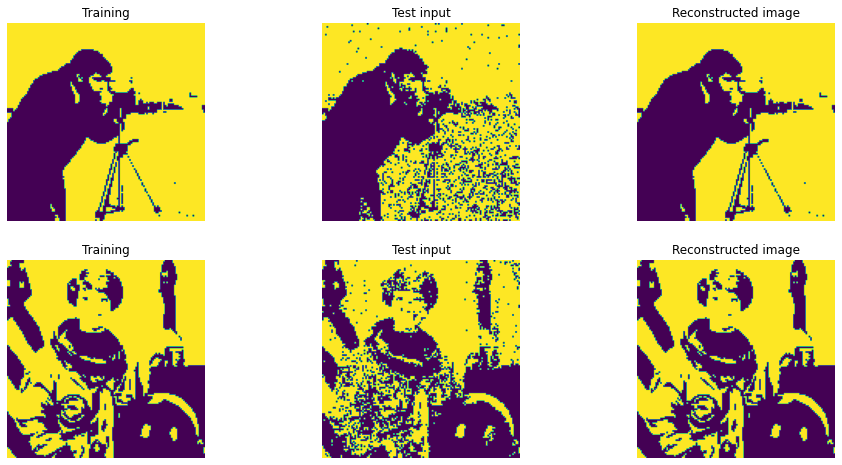

In [11]:
out=[]

for i in tqdm(range(len(test))):
    testr=np.copy(test[i])
    for j in range(it):
        testr=np.sign(w@testr)
    out.append(testr)

out=np.array(out)

plt.figure(figsize=(16,8))
for i in range(len(test)):
    plt.subplot(len(test),3,3*i+1);plot(train[i],ix,iy);plt.title('Training')
    plt.subplot(len(test),3,3*i+2);plot(test[i],ix,iy);plt.title('Test input')
    plt.subplot(len(test),3,3*i+3);plot(out[i],ix,iy);plt.title('Reconstructed image')

# Part 1 : Create Mnist-Fashion array

In [10]:
# Load the fashion Mnist database
fashion_mnist = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# prepare all images using imageprepare function
x_train = np.array([imageprepare(i, 28, 28) for i in x_train])
x_test = np.array([imageprepare(i, 28, 28) for i in x_test])

print(x_train.shape)
print(x_test.shape)


(60000, 784)
(10000, 784)


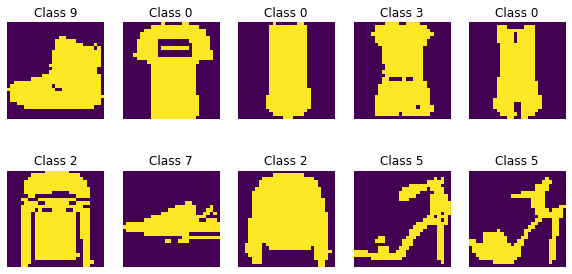

In [12]:
# plot first 10 images of train set with the class as title
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i].reshape(28,28), cmap='viridis')
    plt.title('Class ' + str(y_train[i]))
    plt.axis('off')

In [13]:
nb_classes = 9
train_divided = np.ones((x_train.shape[0], 84, 84))
test_divided = np.ones((x_test.shape[0], 84, 84))

position_array = np.zeros((nb_classes, 4))

# fill the position array with the pixel edges for the different classes as [Xi, Xj, Yi, Yj]
for i in range(int(nb_classes/3)):
    for j in range(int(nb_classes/3)):
        position_array[i*3+j, 0] = 28 * j
        position_array[i*3+j, 1] = 28 + 28 * j
        position_array[i*3+j, 2] = 28 * i
        position_array[i*3+j, 3] = 28 + 28 * i

# make an int array
position_array = position_array.astype(int)
print(position_array)

[[ 0 28  0 28]
 [28 56  0 28]
 [56 84  0 28]
 [ 0 28 28 56]
 [28 56 28 56]
 [56 84 28 56]
 [ 0 28 56 84]
 [28 56 56 84]
 [56 84 56 84]]


In [14]:
# Iterate through the training and test data and add them on different parts of the array depending on their class

for i in range(nb_classes):
    train_class_index = np.where(y_train == i)
    train_divided[train_class_index, position_array[i][0]:position_array[i][1], position_array[i][2]:position_array[i][3]] = x_train[train_class_index].reshape(-1, 28, 28)
    test_class_index = np.where(y_test == i)
    test_divided[test_class_index, position_array[i][0]:position_array[i][1], position_array[i][2]:position_array[i][3]] = x_test[test_class_index].reshape(-1, 28, 28)

# Remove class 9 from the test and train data
y_train_divided = y_train[y_train < 9]
train_divided = train_divided[y_train < 9]
y_test_divided = y_test[y_test < 9]
test_divided = test_divided[y_test < 9]

In [15]:
# Reshape train and test array for training 

train_divided = train_divided.reshape(train_divided.shape[0], 84*84)
test_divided = test_divided.reshape(test_divided.shape[0], 84*84)

ix = 84
iy = 84
it = 1

In [16]:
print(train_divided.shape)
print(test_divided.shape)


(54000, 7056)
(9000, 7056)


In [22]:
# Create a subset of train set 
train_subset = train_divided[:100]

# Auto associative

# Weight initialization

In [ ]:
num_data =  len(train_divided)
num_neuron = train_divided[0].shape[0]

w=np.zeros([num_neuron,num_neuron])
rho=sum(sum(train))/(num_neuron*num_data)

for i in tqdm(range(len(train))):
    imag=train[i]-rho
    w+=np.einsum('i,j->ij',imag,imag)
diagW = np.diag(np.diag(w))
w = w - diagW
w /= num_data